In [36]:
import math
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

In [37]:
@dataclass
class CFG:
    TIMESTEP_MIN: int = 10
    START_DATE: str = "2025-07-23"
    END_DATE: str = "2025-09-18 00:00:00"  # keep anchors up to end of day
    MIN_GAP_STEPS: int = 1
    MAX_GAP_STEPS: int = 1000  # 48h on 10-min grid
    RECENCY_STEPS: Tuple[int, ...] = (6, 36, 144)  # 1h, 6h, 24h
    XGB_PARAMS: dict = None

    def __post_init__(self):
        if self.XGB_PARAMS is None:
            self.XGB_PARAMS = dict(
                n_estimators=250,
                max_depth=4,
                learning_rate=0.05,
                subsample=0.9,
                colsample_bytree=0.9,
                reg_lambda=1.0,
                min_child_weight=2,
                objective="reg:squarederror",
                random_state=42,
                tree_method="hist",
            )

CFG = CFG()

# 10-minute grid -> 3 hours = 18 steps
HL_3H = 18

def ema_exposure(series, half_life_steps):
    alpha = np.exp(-np.log(2) / half_life_steps)
    out = np.zeros(len(series))
    prev = 0.0
    for i, x in enumerate(series.fillna(0.0).values):
        prev = x + alpha * prev
        out[i] = prev
    return out


In [38]:
# Load + prepare master.csv
csv_candidates = [Path("master.csv"), Path("master.csv")]
for p in csv_candidates:
    if p.exists():
        CSV_PATH = p
        break
else:
    raise FileNotFoundError("master.csv not found")

df = pd.read_csv(CSV_PATH)
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df = df.dropna(subset=["timestamp"]).sort_values("timestamp").set_index("timestamp")

# Force numeric where possible
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Reindex to 10-min grid
full_idx = pd.date_range(df.index.min(), df.index.max(), freq=f"{CFG.TIMESTEP_MIN}min")
df = df.reindex(full_idx)

# Keep only requested time range
df = df.loc[pd.Timestamp(CFG.START_DATE): pd.Timestamp(CFG.END_DATE)].copy()

# Columns
TARGET_EC = "ec_ms"
TARGET_PH = "ph"
IRR_COL = "irrigation_ml_current"
CLIMATE_COLS = [c for c in [
    "ET0", "internal_air_temp_c", "internal_rh_%", "soil_temp_pred"
] if c in df.columns]
FERT_COLS = [c for c in df.columns if c not in CLIMATE_COLS + [TARGET_EC, TARGET_PH, IRR_COL,
    "fertilization_flag","fertilization_type_a_flag","fertilization_type_b_flag"] and ("[mg]" in c or "Kortin" in c)]

# Create fert_total_mg if it does not exist
if "fert_total_mg" not in df.columns:
    fert_cols = [c for c in df.columns if "fert" in c.lower()]
    df["fert_total_mg"] = df[fert_cols].sum(axis=1, min_count=1).fillna(0.0)

# 3-hour exposure signals
irr_series = df[IRR_COL] if IRR_COL in df.columns else pd.Series(0.0, index=df.index)
df["irr_exposure_3h"] = ema_exposure(irr_series, HL_3H)
df["fert_exposure_3h"] = ema_exposure(df["fert_total_mg"], HL_3H)

anchors = df.index[df[TARGET_EC].notna() & df[TARGET_PH].notna()]
print("Range:", df.index.min(), "->", df.index.max())
print("Rows:", len(df))
print("True anchors:", len(anchors))
print("Anchor pairs (walk-forward retraining events):", max(0, len(anchors)-1))
print("Fert columns:", FERT_COLS)
df[[TARGET_EC, TARGET_PH]].dropna().head()


Range: 2025-07-23 00:00:00 -> 2025-09-18 00:00:00
Rows: 8209
True anchors: 90
Anchor pairs (walk-forward retraining events): 89
Fert columns: ['Ammonium Nitrate [mg] -NH4NO3', 'Monopotassium Phosphate[mg] -KH2PO4', 'Potassium Chloride[mg] - KCL', 'Phosphoric acid[mg]-H3PO4', 'Kortin [mg]', 'Gypsum - CaSO4*2H2O [mg]']


,ec_ms,ph
2025-07-23 11:30:00,0.3250,6.81
2025-07-23 17:30:00,0.3605,8.14
2025-07-24 11:00:00,0.5821,9.49
2025-07-24 15:10:00,0.5503,9.22
2025-07-27 14:10:00,0.3771,7.65


In [39]:
def _norm_name(col: str) -> str:
    s = col.lower()
    for ch in [" ", "-", "/", "*", "%", "[", "]", "(", ")", "."]:
        s = s.replace(ch, "_")
    while "__" in s:
        s = s.replace("__", "_")
    return s.strip("_")

def compute_window_features(
    window: pd.DataFrame,
    ec_anchor: float,
    ph_anchor: float,
    ec_current: float,
    ph_current: float,
    gap_steps: int,
) -> Dict[str, float]:
    feat: Dict[str, float] = {}

    # state features
    feat["ec_anchor"] = float(ec_anchor)
    feat["ph_anchor"] = float(ph_anchor)
    feat["gap_steps"] = int(gap_steps)

    # exposure features (3h EMA)
    if "irr_exposure_3h" in window.columns and len(window):
        feat["irr_exposure_3h"] = float(window["irr_exposure_3h"].iloc[-1])
    else:
        feat["irr_exposure_3h"] = 0.0
    if "fert_exposure_3h" in window.columns and len(window):
        feat["fert_exposure_3h"] = float(window["fert_exposure_3h"].iloc[-1])
    else:
        feat["fert_exposure_3h"] = 0.0

    # climate (recent windows only)
    for c in CLIMATE_COLS:
        x = window[c].astype(float)
        name = _norm_name(c)
        if name == "et0":
            name = "eto"
        for w in CFG.RECENCY_STEPS:
            s = x.iloc[-w:]
            hrs = int(w * CFG.TIMESTEP_MIN / 60)
            if name == "eto":
                feat[f"{name}_sum_{hrs}h"] = float(s.sum()) if len(s) else 0.0
            else:
                feat[f"{name}_mean_{hrs}h"] = float(s.mean()) if len(s.dropna()) else 0.0

    return feat

# feature list template from a tiny window (will match all generated rows)
tmp_anchor = anchors[0]
tmp_next = anchors[1]
tmp_window = df.loc[tmp_anchor + pd.Timedelta(minutes=CFG.TIMESTEP_MIN): tmp_next]
tmp_feat = compute_window_features(
    tmp_window, ec_anchor=float(df.loc[tmp_anchor, TARGET_EC]), ph_anchor=float(df.loc[tmp_anchor, TARGET_PH]),
    ec_current=float(df.loc[tmp_anchor, TARGET_EC]), ph_current=float(df.loc[tmp_anchor, TARGET_PH]),
    gap_steps=len(tmp_window)
)

EC_FEATURES = [
    "ec_anchor",
    "ph_anchor",
    "gap_steps",
    "eto_sum_6h",
    "eto_sum_24h",
    "soil_temp_pred_mean_1h",
    "soil_temp_pred_mean_6h",
    "internal_rh_mean_24h",
    "irr_exposure_3h",
    "fert_exposure_3h",
]

PH_FEATURES = [
    "ph_anchor",
    "ec_anchor",
    "gap_steps",
    "internal_air_temp_c_mean_1h",
    "internal_air_temp_c_mean_6h",
    "internal_air_temp_c_mean_24h",
    "soil_temp_pred_mean_1h",
    "soil_temp_pred_mean_6h",
    "soil_temp_pred_mean_24h",
    "internal_rh_mean_24h",
    "eto_sum_6h",
    "fert_exposure_3h",
]

missing_ec = [f for f in EC_FEATURES if f not in tmp_feat]
missing_ph = [f for f in PH_FEATURES if f not in tmp_feat]
if missing_ec:
    print("Missing EC features:", missing_ec)
if missing_ph:
    print("Missing pH features:", missing_ph)

print("EC feature count:", len(EC_FEATURES))
print("pH feature count:", len(PH_FEATURES))
EC_FEATURES


EC feature count: 10
pH feature count: 12


['ec_anchor',
 'ph_anchor',
 'gap_steps',
 'eto_sum_6h',
 'eto_sum_24h',
 'soil_temp_pred_mean_1h',
 'soil_temp_pred_mean_6h',
 'internal_rh_mean_24h',
 'irr_exposure_3h',
 'fert_exposure_3h']

In [40]:
def make_window_train_row(df: pd.DataFrame, t0: pd.Timestamp, t1: pd.Timestamp) -> Optional[Dict[str, float]]:
    ec0 = df.at[t0, TARGET_EC]
    ph0 = df.at[t0, TARGET_PH]
    ec1 = df.at[t1, TARGET_EC]
    ph1 = df.at[t1, TARGET_PH]
    if any(pd.isna(v) for v in [ec0, ph0, ec1, ph1]):
        return None

    window = df.loc[t0 + pd.Timedelta(minutes=CFG.TIMESTEP_MIN): t1].copy()
    gap_steps = len(window)
    if gap_steps < CFG.MIN_GAP_STEPS or gap_steps > CFG.MAX_GAP_STEPS:
        return None

    feat = compute_window_features(
        window=window,
        ec_anchor=float(ec0),
        ph_anchor=float(ph0),
        ec_current=float(ec0),   # training target is full anchor-to-anchor cumulative delta
        ph_current=float(ph0),
        gap_steps=gap_steps
    )
    feat["delta_ec"] = float(ec1 - ec0)
    feat["delta_ph"] = float(ph1 - ph0)
    feat["t0"] = t0
    feat["t1"] = t1
    feat["gap_steps_actual"] = gap_steps
    return feat

def train_models(train_rows: pd.DataFrame) -> Tuple[xgb.XGBRegressor, xgb.XGBRegressor]:
    X_ec = train_rows[EC_FEATURES].values
    y_ec = train_rows["delta_ec"].values
    X_ph = train_rows[PH_FEATURES].values
    y_ph = train_rows["delta_ph"].values
    m_ec = xgb.XGBRegressor(**CFG.XGB_PARAMS)
    m_ph = xgb.XGBRegressor(**CFG.XGB_PARAMS)
    m_ec.fit(X_ec, y_ec, verbose=False)
    m_ph.fit(X_ph, y_ph, verbose=False)
    return m_ec, m_ph


In [41]:
def walk_forward_rollout(df: pd.DataFrame, anchors: pd.DatetimeIndex):
    assert len(anchors) >= 2, "Need at least 2 true anchors"

    records = []
    train_rows = []
    model_ec = None
    model_ph = None

    # Start from first true anchor state
    current_anchor = anchors[0]
    ec_anchor = float(df.at[current_anchor, TARGET_EC])
    ph_anchor = float(df.at[current_anchor, TARGET_PH])
    ec_state = ec_anchor
    ph_state = ph_anchor
    prev_cum_ec = 0.0
    prev_cum_ph = 0.0

    retrain_count = 0
    anchor_pair_count = 0
    anchor_iter = iter(anchors[1:])
    next_anchor = next(anchor_iter, None)

    # Save the initial anchor row (state = truth)
    records.append(dict(
        timestamp=current_anchor, pred_ec=ec_state, pred_ph=ph_state,
        true_ec=ec_anchor, true_ph=ph_anchor, is_anchor=True,
        anchor_err_ec=np.nan, anchor_err_ph=np.nan,
        model_ready=False, train_rows_used=0
    ))

    for ts in df.loc[current_anchor + pd.Timedelta(minutes=CFG.TIMESTEP_MIN):].index:
        # If we moved beyond the last anchor, stop (no more error/retrain events)
        if next_anchor is None:
            break

        is_anchor = (ts == next_anchor)

        # window from current anchor + one step to current ts
        window = df.loc[current_anchor + pd.Timedelta(minutes=CFG.TIMESTEP_MIN): ts]
        gap_steps = len(window)

        if model_ec is None or gap_steps < CFG.MIN_GAP_STEPS:
            # bootstrap phase before first completed window: persistence (zero incremental change)
            d_ec = 0.0
            d_ph = 0.0
            cum_ec_delta = 0.0
            cum_ph_delta = 0.0
        else:
            feat = compute_window_features(
                window=window,
                ec_anchor=ec_anchor, ph_anchor=ph_anchor,
                ec_current=ec_state, ph_current=ph_state,
                gap_steps=gap_steps
            )
            x_ec = pd.DataFrame([feat])[EC_FEATURES].values
            x_ph = pd.DataFrame([feat])[PH_FEATURES].values
            cum_ec_delta = float(model_ec.predict(x_ec)[0])
            cum_ph_delta = float(model_ph.predict(x_ph)[0])
            d_ec = cum_ec_delta - prev_cum_ec
            d_ph = cum_ph_delta - prev_cum_ph

        # propagate state with step delta
        ec_state = float(ec_state + d_ec)
        ph_state = float(ph_state + d_ph)
        prev_cum_ec = float(cum_ec_delta)
        prev_cum_ph = float(cum_ph_delta)

        rec = dict(
            timestamp=ts,
            pred_ec=ec_state,
            pred_ph=ph_state,
            true_ec=float(df.at[ts, TARGET_EC]) if is_anchor else np.nan,
            true_ph=float(df.at[ts, TARGET_PH]) if is_anchor else np.nan,
            is_anchor=bool(is_anchor),
            anchor_err_ec=np.nan,
            anchor_err_ph=np.nan,
            model_ready=model_ec is not None,
            train_rows_used=len(train_rows)
        )

        # At anchor: evaluate pre-reset error, then add training row and retrain, then reset to truth
        if is_anchor:
            true_ec = float(df.at[ts, TARGET_EC])
            true_ph = float(df.at[ts, TARGET_PH])

            rec["anchor_err_ec"] = float(ec_state - true_ec)
            rec["anchor_err_ph"] = float(ph_state - true_ph)
            anchor_pair_count += 1

            row = make_window_train_row(df, current_anchor, ts)
            if row is not None:
                train_rows.append(row)
                train_df = pd.DataFrame(train_rows)
                model_ec, model_ph = train_models(train_df)
                retrain_count += 1
                rec["train_rows_used"] = len(train_rows)

            # reset to truth for next segment
            current_anchor = ts
            ec_anchor = true_ec
            ph_anchor = true_ph
            ec_state = true_ec
            ph_state = true_ph
            prev_cum_ec = 0.0
            prev_cum_ph = 0.0
            next_anchor = next(anchor_iter, None)

        records.append(rec)

    pred_df = pd.DataFrame(records).set_index("timestamp")
    train_df = pd.DataFrame(train_rows) if len(train_rows) else pd.DataFrame()
    stats = dict(
        n_true_anchors=len(anchors),
        n_anchor_pairs=max(0, len(anchors)-1),
        retrain_count=retrain_count,
        anchor_pair_count_seen=anchor_pair_count,
        first_anchor=anchors[0],
        last_anchor=anchors[-1],
    )
    return pred_df, train_df, model_ec, model_ph, stats

pred_df, train_rows_df, model_ec_final, model_ph_final, stats = walk_forward_rollout(df, anchors)
stats


{'n_true_anchors': 90,
 'n_anchor_pairs': 89,
 'retrain_count': 89,
 'anchor_pair_count_seen': 89,
 'first_anchor': Timestamp('2025-07-23 11:30:00'),
 'last_anchor': Timestamp('2025-09-17 15:20:00')}

In [42]:
# Single evaluation (pre-reset vs true anchor only)
anchor_eval = pred_df.dropna(subset=["anchor_err_ec", "anchor_err_ph"]).copy()

def metric_summary(s: pd.Series):
    return {
        "n": int(s.notna().sum()),
        "MAE": float(s.abs().mean()),
        "RMSE": float(np.sqrt((s**2).mean())),
        "Bias": float(s.mean()),
    }

ec_metrics = metric_summary(anchor_eval["anchor_err_ec"])
ph_metrics = metric_summary(anchor_eval["anchor_err_ph"])

print("Walk-forward rollout (only evaluation kept)")
print("True anchors:", stats["n_true_anchors"])
print("Anchor pairs:", stats["n_anchor_pairs"])
print("Retraining count:", stats["retrain_count"])
print("Expected retraining count (= n_true_samples - 1):", stats["n_true_anchors"] - 1)
print("\nEC metrics:", ec_metrics)
print("pH metrics:", ph_metrics)

anchor_eval[["pred_ec","true_ec","anchor_err_ec","pred_ph","true_ph","anchor_err_ph","train_rows_used"]].head(10)

Walk-forward rollout (only evaluation kept)
True anchors: 90
Anchor pairs: 89
Retraining count: 89
Expected retraining count (= n_true_samples - 1): 89

EC metrics: {'n': 89, 'MAE': 0.3208585534400055, 'RMSE': 0.5600505668887402, 'Bias': 0.021760821588468208}
pH metrics: {'n': 89, 'MAE': 0.6626480617135596, 'RMSE': 0.8756689190960979, 'Bias': -0.06141521314933395}


,pred_ec,true_ec,anchor_err_ec,pred_ph,true_ph,anchor_err_ph,train_rows_used
timestamp,,,,,,,
2025-07-23 17:30:00,0.325000,0.3605,-0.035500,6.810000,8.14,-1.330000,1
2025-07-24 11:00:00,0.396000,0.5821,-0.186100,9.470000,9.49,-0.020000,2
2025-07-24 15:10:00,0.710650,0.5503,0.160350,10.830000,9.22,1.610000,3
2025-07-27 14:10:00,0.632175,0.3771,0.255075,10.091357,7.65,2.441357,4
2025-07-28 09:00:00,0.582728,0.5411,0.041628,9.013893,7.63,1.383893,5
2025-07-29 15:20:00,0.495446,1.4060,-0.910554,7.294518,8.06,-0.765482,6
2025-07-30 08:30:00,1.499298,0.9185,0.580798,8.713591,7.78,0.933591,7
2025-07-31 09:00:00,0.647333,2.7000,-2.052667,7.391924,7.55,-0.158076,8
2025-07-31 12:00:00,2.846821,0.4112,2.435621,7.892287,7.25,0.642287,9


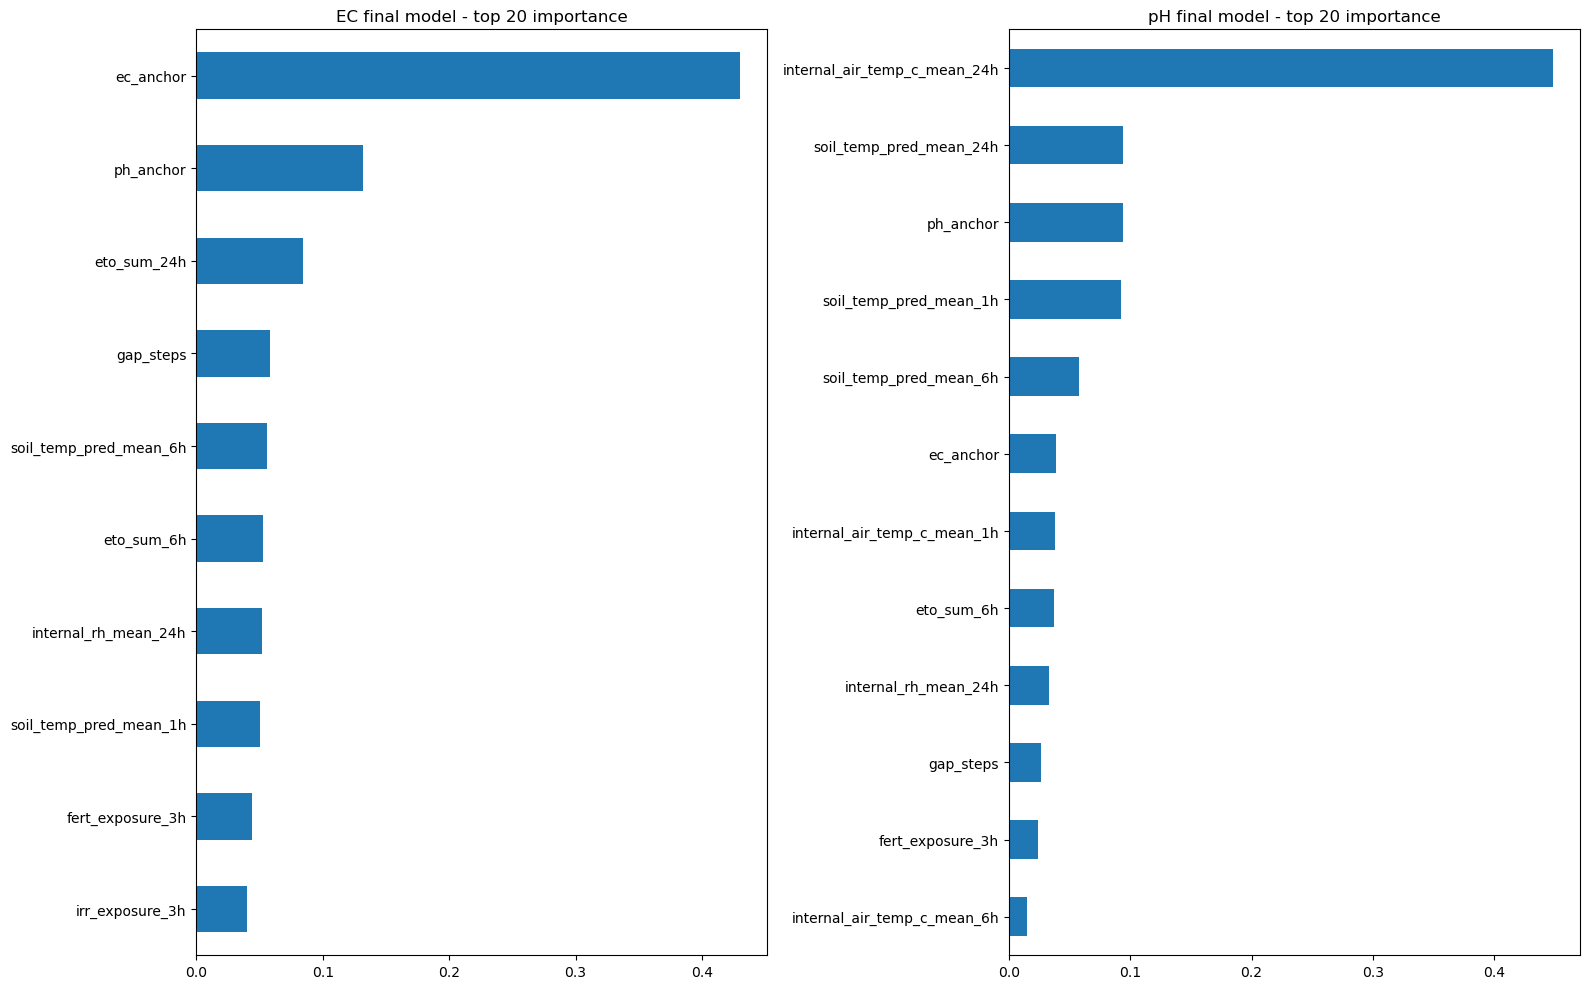

,EC_top_features,EC_importance,pH_top_features,pH_importance
0,ec_anchor,0.430144,internal_air_temp_c_mean_24h,0.448109
1,ph_anchor,0.131476,soil_temp_pred_mean_24h,0.094497
2,eto_sum_24h,0.084167,ph_anchor,0.093996
3,gap_steps,0.058595,soil_temp_pred_mean_1h,0.092436
4,soil_temp_pred_mean_6h,0.056264,soil_temp_pred_mean_6h,0.058028
5,eto_sum_6h,0.052589,ec_anchor,0.039330
6,internal_rh_mean_24h,0.052283,internal_air_temp_c_mean_1h,0.038447
7,soil_temp_pred_mean_1h,0.050239,eto_sum_6h,0.037096
8,fert_exposure_3h,0.044299,internal_rh_mean_24h,0.032771
9,irr_exposure_3h,0.039944,gap_steps,0.026492


In [43]:
# Optional: final-model feature importance (global)
if model_ec_final is not None and model_ph_final is not None:
    imp_ec = pd.Series(model_ec_final.feature_importances_, index=EC_FEATURES).sort_values(ascending=False)
    imp_ph = pd.Series(model_ph_final.feature_importances_, index=PH_FEATURES).sort_values(ascending=False)

    fig, axes = plt.subplots(1, 2, figsize=(16, 10))
    imp_ec.head(20).sort_values().plot(kind="barh", ax=axes[0], title="EC final model - top 20 importance")
    imp_ph.head(20).sort_values().plot(kind="barh", ax=axes[1], title="pH final model - top 20 importance")
    plt.tight_layout()
    plt.show()

    ec_top = imp_ec.head(20).reset_index()
    ph_top = imp_ph.head(20).reset_index()
    ec_top.columns = ["EC_top_features", "EC_importance"]
    ph_top.columns = ["pH_top_features", "pH_importance"]
    display(pd.concat([ec_top, ph_top], axis=1))


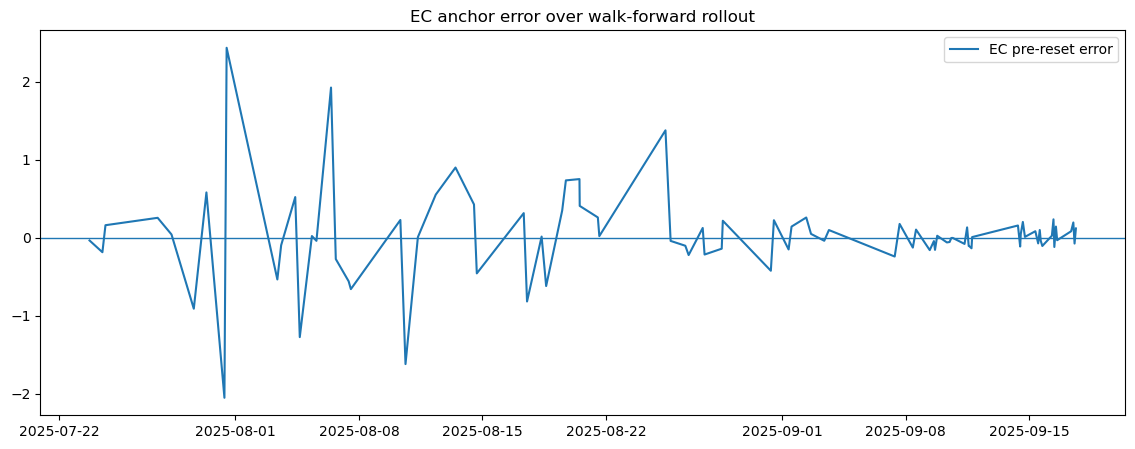

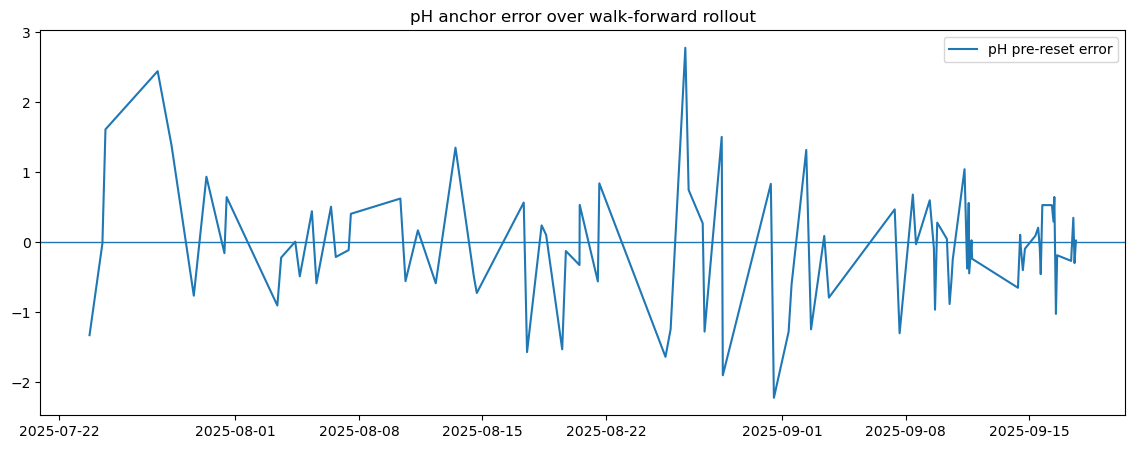

In [44]:
# Optional: anchor error plots
if len(anchor_eval):
    fig = plt.figure(figsize=(14, 5))
    plt.plot(anchor_eval.index, anchor_eval["anchor_err_ec"], label="EC pre-reset error")
    plt.axhline(0, linewidth=1)
    plt.title("EC anchor error over walk-forward rollout")
    plt.legend()
    plt.show()

    fig = plt.figure(figsize=(14, 5))
    plt.plot(anchor_eval.index, anchor_eval["anchor_err_ph"], label="pH pre-reset error")
    plt.axhline(0, linewidth=1)
    plt.title("pH anchor error over walk-forward rollout")
    plt.legend()
    plt.show()